#### **Project Overview**
To develop a recommendation system using MovieLens dataset. The proposed recommendation system will suggest to users of the site, movies based off of their preference and ratings. This will be relaying on both collaborative filtering and clustering techniques. 

#### **Background**
In an era of where there is information overload, recommendation systems have become indispensable for personalizing user experiences in a wide range of applications. Streaming platforms such as *Netflix, Amazon Prime, and Disney+* depend heavily on recommendation algorithms to suggest movies or TV shows based on how their users interact with their content, relying on their preferences.

MovieLens, is a public dataset, that provides an opportunity to develop and test recommendation models that can be applied to real-world scenarios. Movie recommendation systems help enhance user engagement, increase satisfaction, and improve overall platform experience by narrowing down wide content libraries to highly relevant options. This project focuses on building such a system using established methods like collaborative filtering and addressing common challenges like cold start, where there is a lack of sufficient data for new users or movies

#### **Problem Statement**
This project aims to address is how to recommend movies to users in a personalized manner based on their previous viewing and rating history. Generally, the recommendation system should answer:
- How can we provide the top 5 movie recommendations for each user based on their past ratings?
- How can we improve recommendations for new users or new movies where there is limited rating data?

By implementing a recommendation system using collaborative filtering, *the project aims to learn from user interactions with movies (ratings) and predict preferences*. To further address situations where there is not enough rating data (the cold start problem), a hybrid approach incorporating content-based filtering will be explored. Finally, evaluation metrics such as RMSE and MAE will be used to gauge the accuracy of the predictions.


**Importing neccesary libraries**

In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate


**Loading the dataset**

In [2]:
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')

### **Data Exploration**

**Displaying the first few rows of the datasets**

In [3]:
#Movies csv
movies.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Ratings csv
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


**Merging the datasets**

In [5]:
df= pd.merge(ratings, movies, on='movieId')

In [6]:
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


**Describing the data**

In [7]:
df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


### **Data cleaning**

In [8]:
df.isnull()

,userId,movieId,rating,timestamp,title,genres
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
...,...,...,...,...,...,...
100831,False,False,False,False,False,False
100832,False,False,False,False,False,False
100833,False,False,False,False,False,False
100834,False,False,False,False,False,False


The dataset has no missing values.

**Converting the genres into separate columns using one-hot encoding**

In [9]:
genres = df['genres'].str.get_dummies(sep='|')
df = pd.concat([df, genres], axis=1)

In [10]:
df_clean = df[['userId', 'movieId', 'rating', 'timestamp'] + list(genres.columns)]

### **Data Understanding**

**Distribution of the ratings**

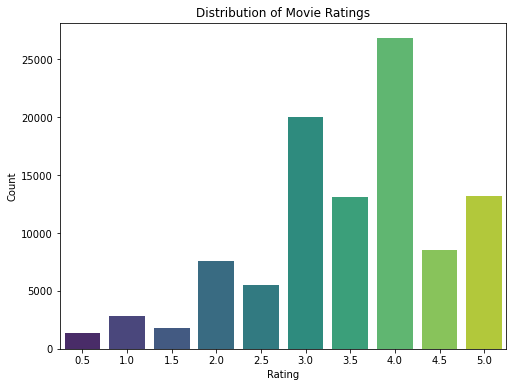

In [11]:
plt.figure(figsize=(8, 6))
sns.countplot(data=ratings, x='rating', palette='viridis')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


- The bar chart displays how movie ratings are spread out, with most ratings grouped around higher numbers, especially around 3.0 and 4.0. This shows a positive baisness that means that users usually give movies good ratings.

In [12]:
num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()

print(f"\nNumber of unique users: {num_users}")
print(f"Number of unique movies: {num_movies}")


Number of unique users: 610
Number of unique movies: 9724


- There are **610 unique users** in the dataset, which means that 610 different individuals have rated movies. Additionally, there are **9,724 unique movies** and this indicates that this dataset contains ratings for 9,724 different films. 
- Therefore the information in the dataset showcases the diversity of both  the audience and the movie selection available in the dataset.

**Finding the top 10 rated movies in the dataset**

In [13]:
top_rated_movies = df.groupby('title').size().sort_values(ascending=False).head(10)

top_rated_movies

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
dtype: int64

**Visualizing the most rated movies alongside the number of ratings for each movie**

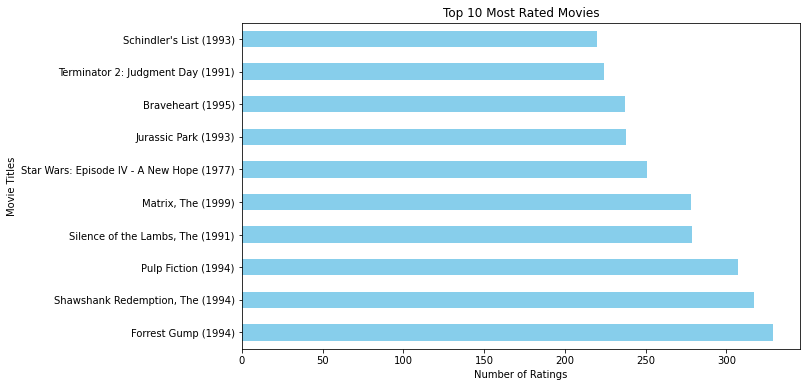

In [14]:
plt.figure(figsize=(10, 6))
top_rated_movies.plot(kind='barh', color='skyblue')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Titles')
plt.show()


**Understanding the individual rating of the movies**

In [15]:
# Explore rating statistics per movie
movie_ratings = df.groupby('title')['rating'].agg(['mean', 'count']).sort_values(by='count', ascending=False)
print("\nRating Statistics per Movie:")
print(movie_ratings.head(10))


Rating Statistics per Movie:
                                               mean  count
title                                                     
Forrest Gump (1994)                        4.164134    329
Shawshank Redemption, The (1994)           4.429022    317
Pulp Fiction (1994)                        4.197068    307
Silence of the Lambs, The (1991)           4.161290    279
Matrix, The (1999)                         4.192446    278
Star Wars: Episode IV - A New Hope (1977)  4.231076    251
Jurassic Park (1993)                       3.750000    238
Braveheart (1995)                          4.031646    237
Terminator 2: Judgment Day (1991)          3.970982    224
Schindler's List (1993)                    4.225000    220


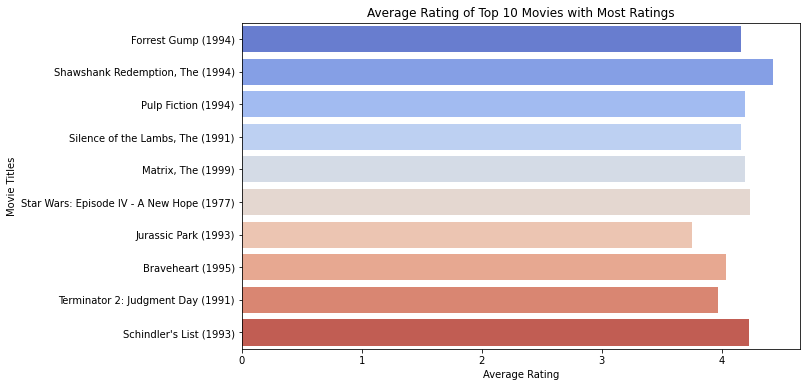

In [16]:
# Visualizing the average rating of top 10 movies with most ratings
top_10_movies = movie_ratings.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_movies['mean'], y=top_10_movies.index, palette='coolwarm')
plt.title('Average Rating of Top 10 Movies with Most Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Movie Titles')
plt.show()